### Imports 

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
import lightgbm as lgb

### Const and Func

In [4]:
path = Path('data/dataset/')

In [5]:
path

PosixPath('data/dataset')

In [6]:
! ls {path}

!dataset_fields_description.xlsx sample-submit-zero.csv
bs_avg_kpi.csv                   test
bs_chnn_kpi.csv                  train


In [7]:
! ls {path/'train'}

subs_bs_consumption_train.csv   subs_csi_train.csv
subs_bs_data_session_train.csv  subs_features_train.csv
subs_bs_voice_session_train.csv


In [8]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

### Loads

In [9]:
train_ids = pd.read_csv(path/'train/subs_csi_train.csv', sep=';')

In [10]:
test_ids = pd.read_csv(path/'test/subs_csi_test.csv', sep=';')

In [11]:
features_train = pd.read_csv(path/'train/subs_features_train.csv', sep=';', decimal=',', 
                              parse_dates=['SNAP_DATE'], infer_datetime_format=True, dayfirst=True)

In [12]:
features_test = pd.read_csv(path/'test/subs_features_test.csv', sep=';', decimal=',', 
                              parse_dates=['SNAP_DATE'], infer_datetime_format=True, dayfirst=True)

In [13]:
# convert to months (int)
features_train.SNAP_DATE = features_train.SNAP_DATE.dt.month

In [14]:
# convert to months (int)
features_test.SNAP_DATE = features_test.SNAP_DATE.dt.month

###  Data processing

In [15]:
train_ids.SK_ID.nunique(), features_train.SK_ID.nunique()

(4222, 4222)

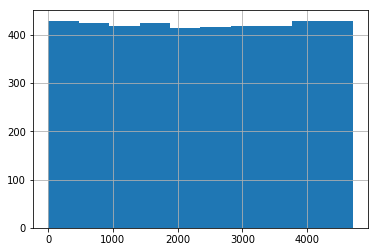

In [16]:
train_ids.SK_ID.hist();

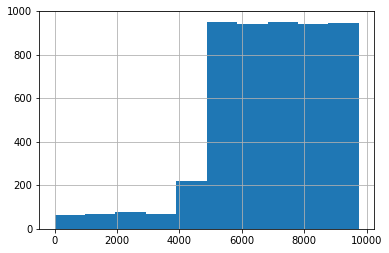

In [17]:
test_ids.SK_ID.hist();

#### Time split valid

In [18]:
features_test.SNAP_DATE.unique()

array([10,  7,  6,  1,  8,  4,  5, 11,  9,  2, 12,  3])

In [19]:
raw_train = features_train[features_train.SNAP_DATE.isin([1,2,3])].copy()
raw_valid = features_train[features_train.SNAP_DATE.isin([4,5])].copy()
raw_test = features_test[features_test.SNAP_DATE.isin([1,2,3,4])].copy()

### Aggregation

In [20]:
raw_train.head()

,SNAP_DATE,COM_CAT#1,SK_ID,COM_CAT#2,COM_CAT#3,BASE_TYPE,ACT,ARPU_GROUP,COM_CAT#7,COM_CAT#8,...,COM_CAT#25,COM_CAT#26,COM_CAT#27,COM_CAT#28,COM_CAT#29,COM_CAT#30,COM_CAT#31,COM_CAT#32,COM_CAT#33,COM_CAT#34
570,1,4,238,75,5,2,1,8.0,1,945.0,...,1,1,0.009408,0.016091,0.000000,0.0,0.043079,0.027579,0.103896,3.0
571,1,4,1293,70,5,2,1,6.0,1,720.0,...,1,1,0.001875,0.001785,0.004100,0.0,0.060689,0.027579,0.103896,7.0
572,1,4,1620,47,5,2,1,7.0,1,1620.0,...,1,1,0.005866,0.002898,0.000000,0.0,0.287902,0.027579,0.103896,1.0
573,1,4,1393,38,5,2,1,6.0,3,1399.0,...,1,1,0.020422,0.012353,0.000000,0.0,0.025244,0.027579,0.103896,3.0
574,1,4,624,36,5,2,1,10.0,1,1627.0,...,1,1,0.016859,0.005389,0.113934,0.0,0.039788,0.027579,0.103896,2.0


In [21]:
for df in (raw_train, raw_valid, raw_test):
    df.drop('SNAP_DATE', axis=1, inplace=True)

In [22]:
for df in (raw_train, raw_valid, raw_test):
    print('====')
    for n, c in df.iteritems():
        if c.nunique() < 10:
            print(n, '-->', c.nunique(), c.dtype)

====
COM_CAT#1 --> 8 int64
BASE_TYPE --> 2 int64
ACT --> 2 int64
COM_CAT#7 --> 9 int64
DEVICE_TYPE_ID --> 7 float64
INTERNET_TYPE_ID --> 3 float64
COM_CAT#24 --> 1 object
COM_CAT#25 --> 1 int64
COM_CAT#26 --> 2 int64
====
COM_CAT#1 --> 8 int64
BASE_TYPE --> 2 int64
ACT --> 2 int64
COM_CAT#7 --> 9 int64
DEVICE_TYPE_ID --> 5 float64
INTERNET_TYPE_ID --> 3 float64
COM_CAT#24 --> 8 object
COM_CAT#25 --> 2 int64
COM_CAT#26 --> 2 int64
====
COM_CAT#1 --> 8 int64
BASE_TYPE --> 2 int64
ACT --> 2 int64
COM_CAT#7 --> 9 int64
DEVICE_TYPE_ID --> 8 float64
INTERNET_TYPE_ID --> 3 float64
COM_CAT#24 --> 7 object
COM_CAT#25 --> 2 int64
COM_CAT#26 --> 2 int64


In [23]:
for df in (raw_train, raw_valid, raw_test):
    df.drop('COM_CAT#24', axis=1, inplace=True)

In [24]:
tr_gr = raw_train.groupby('SK_ID', as_index=False).agg(['size', 'mean', 'max', 'min'])
val_gr = raw_valid.groupby('SK_ID', as_index=False).agg(['size', 'mean', 'max', 'min'])
test_gr = raw_test.groupby('SK_ID', as_index=False).agg(['size', 'mean', 'max', 'min'])

In [25]:
for df in (tr_gr, val_gr, test_gr):
    df.columns = ['_'.join(c) for c in df.columns]

In [28]:
# add contact date and labels
tr_gr = pd.merge(tr_gr, train_ids, on='SK_ID')
val_gr = pd.merge(val_gr, train_ids, on='SK_ID')

In [29]:
test_gr = pd.merge(test_ids, test_gr, on='SK_ID', how='left')

In [35]:
for df in (tr_gr, val_gr, test_gr):
    df['CONTACT_DATE'] = pd.to_datetime(df['CONTACT_DATE'], format='%d.%m').dt.day

In [36]:
(tr_gr.shape, val_gr.shape, test_gr.shape)

((4114, 135), (4201, 135), (5221, 134))

### Train

In [56]:
df, y, nas = proc_df(tr_gr.drop(['SK_ID','CONTACT_DATE'], axis=1), 'CSI')

In [57]:
test, _, _ = proc_df(test_gr.drop(['SK_ID','CONTACT_DATE'], axis=1), na_dict=nas)

In [42]:
X_train, y_train, nas = proc_df(tr_gr.drop(['SK_ID','CONTACT_DATE'], axis=1), 'CSI')
X_valid, y_valid, _ = proc_df(val_gr.drop(['SK_ID','CONTACT_DATE'], axis=1),'CSI', na_dict=nas)

In [226]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=10)
m.fit(df, y)
m.score(df, y)

0.9735051045211472

In [227]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 400
n_trn = len(df)-n_valid
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

In [43]:
X_valid.shape

(4201, 144)

In [46]:
X_valid.head()

,COM_CAT#1_size,COM_CAT#1_mean,COM_CAT#1_max,COM_CAT#1_min,COM_CAT#2_size,COM_CAT#2_mean,COM_CAT#2_max,COM_CAT#2_min,COM_CAT#3_size,COM_CAT#3_mean,...,COM_CAT#8_min_na,DEVICE_TYPE_ID_mean_na,DEVICE_TYPE_ID_max_na,DEVICE_TYPE_ID_min_na,INTERNET_TYPE_ID_mean_na,INTERNET_TYPE_ID_max_na,INTERNET_TYPE_ID_min_na,COM_CAT#34_mean_na,COM_CAT#34_max_na,COM_CAT#34_min_na
0,2,7,7,7,2,77.0,77,77,2,11.5,...,False,False,False,False,False,False,False,False,False,False
1,2,4,4,4,2,51.0,51,51,2,15.5,...,False,False,False,False,False,False,False,False,False,False
2,2,8,8,8,2,12.0,12,12,2,5.0,...,False,False,False,False,False,False,False,False,False,False
3,2,3,3,3,2,79.0,79,79,2,3.0,...,False,False,False,False,False,False,False,False,False,False
4,2,5,5,5,2,48.0,48,48,2,5.0,...,False,False,False,False,False,False,False,False,False,False


In [44]:
def print_score(m):
    res = [metrics.roc_auc_score(y_train, m.predict_proba(X_train)[:,1]), 
           metrics.roc_auc_score(y_valid, m.predict_proba(X_valid)[:,1]),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [48]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=100, min_samples_leaf=12, max_features=0.8, 
                           random_state=111, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9928893166351009, 0.6937061679864889, 0.8437044239183277, 0.8447988574149012, 0.8437044239183277]


In [47]:
m = lgb.LGBMClassifier()
m.fit(X_train, y_train)
print_score(m)

[0.9996693330609139, 0.6970610402653818, 0.9535731648031113, 0.8474172815996192]


### Feature Importance 

In [50]:
fi = rf_feat_importance(m, X_train)

In [51]:
fi[:10]

,cols,imp
54,RENT_CHANNEL_max,0.032883
119,COM_CAT#31_min,0.031393
103,COM_CAT#27_min,0.030820
102,COM_CAT#27_max,0.029766
118,COM_CAT#31_max,0.029458
117,COM_CAT#31_mean,0.027960
55,RENT_CHANNEL_min,0.027476
62,COST_max,0.027353
31,COM_CAT#8_min,0.026110
50,VAS_max,0.025408


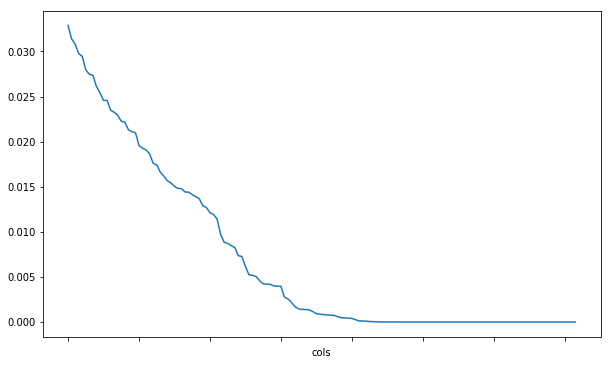

In [52]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [53]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

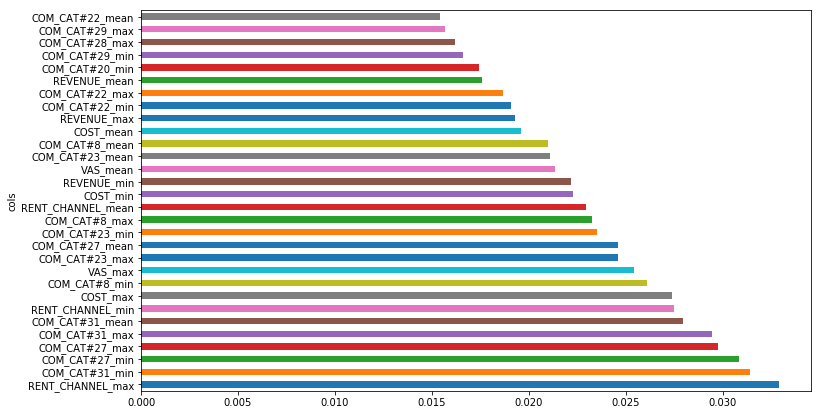

In [54]:
plot_fi(fi[:30]);

In [55]:
fi.describe()

,imp
count,144.000000
mean,0.006944
std,0.009486
min,0.000000
25%,0.000000
50%,0.000838
75%,0.013962
max,0.032883


In [255]:
to_keep = fi[fi.imp>0.02].cols; len(to_keep)

20

In [256]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [257]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=100, min_samples_leaf=12, max_features=0.8, 
                           random_state=111, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.9905183680740748, 0.5154173588039866, 0.8422186322024772, 0.86, 0.841949380721594]


### Predict on test and submit

In [58]:
m = RandomForestClassifier(n_jobs=-1, n_estimators=100, min_samples_leaf=12, max_features=0.8, 
                           random_state=111)
m.fit(df, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.8, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=12, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=111, verbose=0, warm_start=False)

In [173]:
m = lgb.LGBMClassifier()
m.fit(df, y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [59]:
pred_y = m.predict_proba(test)[:,1]

In [60]:
subm = pd.DataFrame(pred_y)

In [61]:
subm.shape

(5221, 1)

In [62]:
subm.to_csv('submits/new_rf_time_split_validation.csv', index=False, header=False)